In [1]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_dataset/no/28 no.jpg  
  inflati

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [3]:
def crop_brain_contour(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]         

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

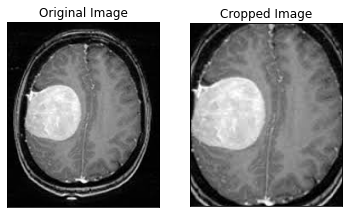

In [4]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [5]:
def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)   
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [6]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir
import time    

%matplotlib inline

In [7]:
def augment_data(file_dir, n_generated_samples, save_to_dir):   
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )
    for filename in listdir(file_dir):
        print(file_dir,filename)
        print(file_dir + '/' + filename)
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [8]:
yes_path='/content/yes'
no_path='/content/no' 

In [10]:
augmented_data_path = '/content/augmented data/'
augment_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augment_data(file_dir=no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

/content/yes Y16.JPG
/content/yes/Y16.JPG
/content/yes Y50.JPG
/content/yes/Y50.JPG
/content/yes Y73.jpg
/content/yes/Y73.jpg
/content/yes Y184.JPG
/content/yes/Y184.JPG
/content/yes Y91.jpg
/content/yes/Y91.jpg
/content/yes Y253.JPG
/content/yes/Y253.JPG
/content/yes Y82.jpg
/content/yes/Y82.jpg
/content/yes Y77.jpg
/content/yes/Y77.jpg
/content/yes Y53.jpg
/content/yes/Y53.jpg
/content/yes Y146.JPG
/content/yes/Y146.JPG
/content/yes Y183.jpg
/content/yes/Y183.jpg
/content/yes Y76.jpg
/content/yes/Y76.jpg
/content/yes Y81.jpg
/content/yes/Y81.jpg
/content/yes Y159.JPG
/content/yes/Y159.JPG
/content/yes Y156.JPG
/content/yes/Y156.JPG
/content/yes Y257.jpg
/content/yes/Y257.jpg
/content/yes Y193.JPG
/content/yes/Y193.JPG
/content/yes Y12.jpg
/content/yes/Y12.jpg
/content/yes Y100.JPG
/content/yes/Y100.JPG
/content/yes Y42.jpg
/content/yes/Y42.jpg
/content/yes Y92.png
/content/yes/Y92.png
/content/yes Y169.jpg
/content/yes/Y169.jpg
/content/yes Y79.jpg
/content/yes/Y79.jpg
/content/yes Y

In [11]:
def data_summary(main_path):
    
    yes_path = main_path+'yes'
    no_path = main_path+'no'
    m_pos = len(listdir(yes_path))
    m_neg = len(listdir(no_path))
    m = (m_pos+m_neg)    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 

In [12]:
data_summary(augmented_data_path)

Number of examples: 2063
Percentage of positive examples: 52.49636451769268%, number of pos examples: 1083
Percentage of negative examples: 47.50363548230732%, number of neg examples: 980


In [13]:
augmented_path = '/content/augmented data/'
augmented_yes ='/content/augmented data/yes'
augmented_no = '/content/augmented data/no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2063
X shape is: (2063, 240, 240, 3)
y shape is: (2063, 1)


In [14]:
X

array([[[[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],

        ...,

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]

In [15]:
def plot_sample_images(X, y, n=50):
   
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

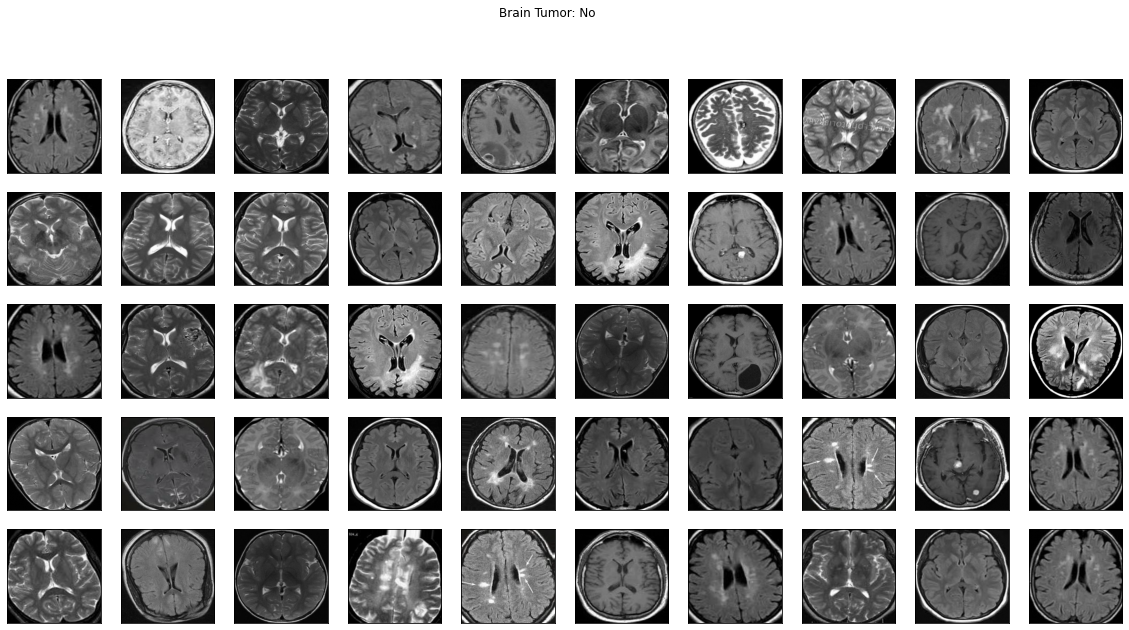

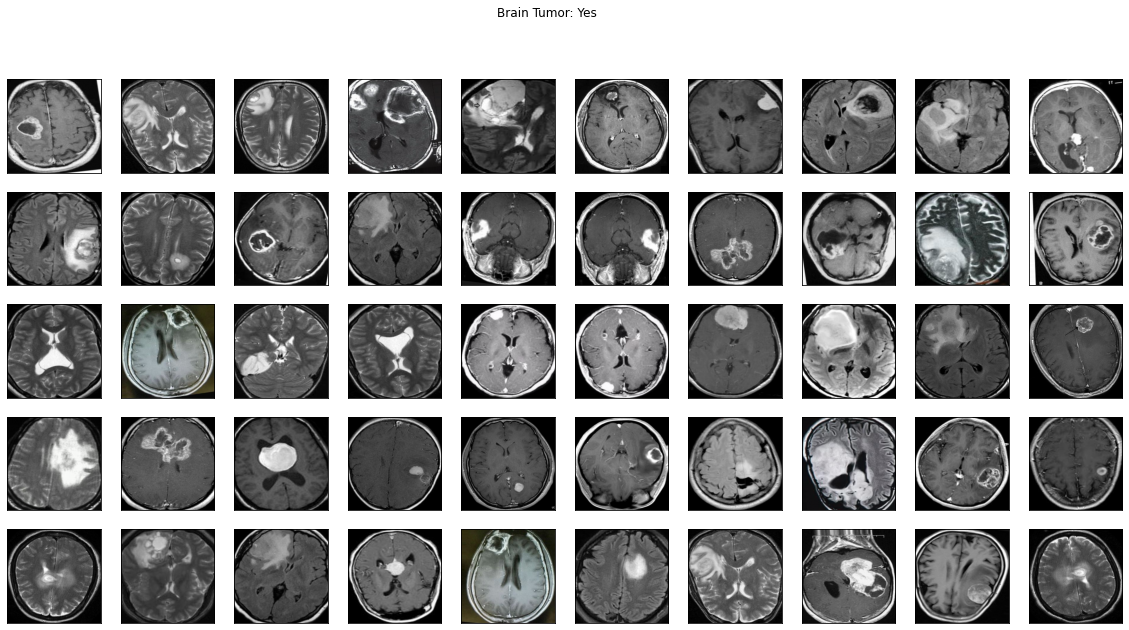

In [16]:
plot_sample_images(X, y)

In [17]:
def split_data(X, y, test_size=0.2):   
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)  
    return X_train, y_train, X_val, y_val, X_test, y_test

In [18]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [19]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1444
number of development examples = 310
number of test examples = 309
X_train shape: (1444, 240, 240, 3)
Y_train shape: (1444, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (309, 240, 240, 3)
Y_test shape: (309, 1)


In [20]:
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)    
    score = f1_score(y_true, y_pred)    
    return score

In [21]:
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    X = MaxPooling2D((4, 4), name='max_pool1')(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    return model

In [22]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [23]:
model = build_model(IMG_SHAPE)

In [24]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

Compile the model:

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [27]:
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [28]:
model.fit(x=X_train, y=y_train, batch_size=16, epochs=15, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

Epoch 1/15
91/91 [==============================] - 86s 932ms/step - loss: 0.6474 - accuracy: 0.6877 - val_loss: 0.6369 - val_accuracy: 0.6032
Epoch 2/15
91/91 [==============================] - 86s 942ms/step - loss: 0.4326 - accuracy: 0.8102 - val_loss: 0.5298 - val_accuracy: 0.7258
Epoch 3/15
91/91 [==============================] - 79s 873ms/step - loss: 0.3636 - accuracy: 0.8463 - val_loss: 0.4286 - val_accuracy: 0.7935
Epoch 4/15
91/91 [==============================] - 81s 884ms/step - loss: 0.3342 - accuracy: 0.8573 - val_loss: 0.3539 - val_accuracy: 0.8484
Epoch 5/15
91/91 [==============================] - 81s 890ms/step - loss: 0.3191 - accuracy: 0.8719 - val_loss: 1.0326 - val_accuracy: 0.6161
Epoch 6/15
91/91 [==============================] - 80s 883ms/step - loss: 0.2789 - accuracy: 0.8816 - val_loss: 0.6169 - val_accuracy: 0.7258
Epoch 7/15
91/91 [==============================] - 79s 865ms/step - loss: 0.3627 - accuracy: 0.8421 - val_loss: 0.3274 - val_accuracy: 0.8613

In [29]:
model.fit(x=X_train, y=y_train, batch_size=16, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

Epoch 1/3
91/91 [==============================] - 78s 858ms/step - loss: 0.1124 - accuracy: 0.9640 - val_loss: 0.3542 - val_accuracy: 0.8645
Epoch 2/3
91/91 [==============================] - 78s 858ms/step - loss: 0.0863 - accuracy: 0.9744 - val_loss: 0.3166 - val_accuracy: 0.8677
Epoch 3/3
91/91 [==============================] - 77s 852ms/step - loss: 0.1510 - accuracy: 0.9363 - val_loss: 0.4078 - val_accuracy: 0.8484


In [30]:
model.fit(x=X_train, y=y_train, batch_size=16, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

Epoch 1/5
91/91 [==============================] - 78s 853ms/step - loss: 0.1139 - accuracy: 0.9598 - val_loss: 0.3330 - val_accuracy: 0.8677
Epoch 2/5
91/91 [==============================] - 78s 856ms/step - loss: 0.0832 - accuracy: 0.9723 - val_loss: 0.3920 - val_accuracy: 0.8548
Epoch 3/5
91/91 [==============================] - 78s 853ms/step - loss: 0.1306 - accuracy: 0.9467 - val_loss: 0.8482 - val_accuracy: 0.7581
Epoch 4/5
91/91 [==============================] - 79s 869ms/step - loss: 0.0614 - accuracy: 0.9820 - val_loss: 0.6485 - val_accuracy: 0.7806
Epoch 5/5
91/91 [==============================] - 84s 928ms/step - loss: 0.0766 - accuracy: 0.9723 - val_loss: 0.3396 - val_accuracy: 0.8710


In [31]:
model.fit(x=X_train, y=y_train, batch_size=16, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

Epoch 1/5
91/91 [==============================] - 78s 861ms/step - loss: 0.0652 - accuracy: 0.9778 - val_loss: 0.3342 - val_accuracy: 0.8839
Epoch 2/5
91/91 [==============================] - 80s 878ms/step - loss: 0.0661 - accuracy: 0.9806 - val_loss: 0.7185 - val_accuracy: 0.7774
Epoch 3/5
91/91 [==============================] - 78s 858ms/step - loss: 0.0549 - accuracy: 0.9834 - val_loss: 0.5586 - val_accuracy: 0.8161
Epoch 4/5
91/91 [==============================] - 79s 867ms/step - loss: 0.0491 - accuracy: 0.9875 - val_loss: 0.3278 - val_accuracy: 0.8806
Epoch 5/5
91/91 [==============================] - 80s 880ms/step - loss: 0.0570 - accuracy: 0.9841 - val_loss: 0.6583 - val_accuracy: 0.7968


In [32]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

Epoch 1/5
46/46 [==============================] - 79s 2s/step - loss: 0.0429 - accuracy: 0.9917 - val_loss: 0.4013 - val_accuracy: 0.8677
Epoch 2/5
46/46 [==============================] - 77s 2s/step - loss: 0.0238 - accuracy: 0.9986 - val_loss: 0.3312 - val_accuracy: 0.8806
Epoch 3/5
46/46 [==============================] - 79s 2s/step - loss: 0.0292 - accuracy: 0.9958 - val_loss: 0.4456 - val_accuracy: 0.8645
Epoch 4/5
46/46 [==============================] - 78s 2s/step - loss: 0.0265 - accuracy: 0.9986 - val_loss: 0.3035 - val_accuracy: 0.8806
Epoch 5/5
46/46 [==============================] - 79s 2s/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.3519 - val_accuracy: 0.8806


In [33]:
history = model.history.history

In [34]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


## Plot Loss & Accuracy

In [35]:
def plot_metrics(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

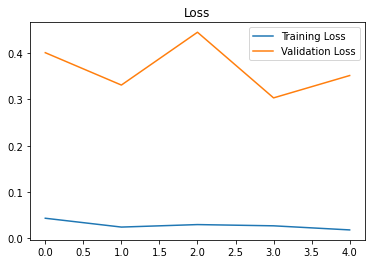

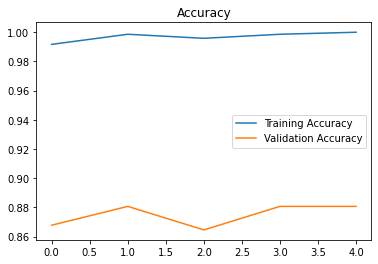

In [36]:
plot_metrics(history) 

In [37]:
model.save('bestmodel')


INFO:tensorflow:Assets written to: bestmodel/assets


In [53]:
best_model = load_model(filepath='/content/bestmodel')

In [54]:
best_model.metrics_names

['loss', 'accuracy']

In [55]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 4s 354ms/step - loss: 0.3329 - accuracy: 0.9094


In [56]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.33288657665252686
Test Accuracy = 0.909385085105896


In [42]:
y_test_prob = best_model.predict(X_test)

In [43]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9078947368421053


In [44]:
y_val_prob = best_model.predict(X_val)

In [45]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8832807570977917


In [46]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [47]:
data_percentage(y)

Number of examples: 2063
Percentage of positive examples: 52.49636451769268%, number of pos examples: 1083
Percentage of negative examples: 47.50363548230732%, number of neg examples: 980


In [48]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1444
Percentage of positive examples: 52.56232686980609%, number of pos examples: 759
Percentage of negative examples: 47.43767313019391%, number of neg examples: 685
Validation Data:
Number of examples: 310
Percentage of positive examples: 53.87096774193548%, number of pos examples: 167
Percentage of negative examples: 46.12903225806452%, number of neg examples: 143
Testing Data:
Number of examples: 309
Percentage of positive examples: 50.80906148867314%, number of pos examples: 157
Percentage of negative examples: 49.19093851132686%, number of neg examples: 152
